In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
import muon as mu
import scanpy as sc
import umap
import pandas as pd
import numpy as np

import muvi

/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# plotting settings
# sns.set()
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("notebook")

In [5]:
def load_mdata(data="208", union=False, shuffle=False):

    if data == "208":
        path = "../../muvi-framework/data/sln_208.h5ad"
    if data == "111":
        path = "../../muvi-framework/data/sln_111.h5ad"

    relevant_cell_types = [
        "Activated CD4 T",
        # 'B doublets',
        # 'B-CD4 T cell doublets',
        # 'B-CD8 T cell doublets',
        # 'B-macrophage doublets',
        "B1 B",
        "CD122+ CD8 T",
        "CD4 T",
        "CD8 T",
        # 'Cycling B/T cells',
        "Erythrocytes",
        "GD T",
        "ICOS-high Tregs",
        "Ifit3-high B",
        "Ifit3-high CD4 T",
        "Ifit3-high CD8 T",
        # 'Low quality B cells',
        # 'Low quality T cells',
        "Ly6-high mono",
        "Ly6-low mono",
        "MZ B",
        "MZ/Marco-high macrophages",
        "Mature B",
        "Migratory DCs",
        "NK",
        "NKT",
        "Neutrophils",
        "Plasma B",
        "Red-pulp macrophages",
        # 'T doublets',
        "Transitional B",
        "Tregs",
        "cDC1s",
        "cDC2s",
        "pDCs",
    ]

    adata = sc.read_h5ad(path)
    adata.var_names_make_unique()
    adata.X = np.array(adata.X.todense(), dtype=np.float32)

    adata.obs_names = adata.obs_names.str.upper()
    adata.var_names = adata.var_names.str.upper()

    adata._inplace_subset_var(adata.var["highly_variable"])

    adata._inplace_subset_obs(adata.obs["cell_types"].isin(relevant_cell_types))
    adata.obs["cell_types"] = adata.obs["cell_types"].cat.remove_unused_categories()
    adata.obs["source"] = data

    prot_df = pd.DataFrame(
        adata.obsm["protein_expression"],
        index=adata.obs_names,
        columns=pd.Index(adata.uns["protein_names"]).str.upper(),
        dtype=np.float32,
    )
    if not union:
        prot_df = prot_df.dropna(axis=1, how="all")
    if shuffle:
        shuffled_obs = adata.obs_names[np.random.permutation(adata.n_obs)]
        adata = adata[shuffled_obs, :].copy()
        prot_df = prot_df.loc[shuffled_obs, :].copy()
    prot_adata = sc.AnnData(prot_df)
    return mu.MuData(
        {
            "rna": adata,
            "prot": prot_adata,
        }
    )

In [6]:
def merge_mdata(mdata_1, mdata_2):
    adata_dict = {}
    for k in mdata_1.mod.keys():
        df_1 = mdata_1[k].to_df()
        obs_1 = mdata_1[k].obs.copy()
        var_1 = mdata_1[k].var.copy()

        df_2 = mdata_2[k].to_df()
        obs_2 = mdata_2[k].obs.copy()
        var_2 = mdata_2[k].var.copy()
        # assert (var_1 == var_2).all(None)

        df_concat = pd.concat([df_1, df_2])
        unique_indices = ~df_concat.index.duplicated(False)
        df_concat = df_concat.loc[unique_indices, :].copy()
        # assert (df_1.columns == df_concat.columns).all()

        obs_1["source"] = 1
        obs_2["source"] = 2
        obs_concat = pd.concat([obs_1, obs_2]).loc[unique_indices, :].copy()

        adata_dict[k] = sc.AnnData(df_concat, obs=obs_concat, var=var_1)

    return mu.MuData(adata_dict)

In [7]:
mdata_208 = load_mdata("208", shuffle=False)
mdata_111 = load_mdata("111", shuffle=False)

# TODO: IF YOU MERGE MAKE SURE TO SET shuffle=False!
# mdata = merge_mdata(mdata_208, mdata_111)
mdata = mdata_208
mdata

/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0

MuData object with n_obs × n_vars = 14870 × 4112
  2 modalities
    rna:	14870 x 4000
      obs:	'n_proteins', 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'source'
      var:	'gene_ids', 'feature_types', 'highly_variable', 'encode', 'hvg_encode'
      uns:	'protein_names', 'version'
      obsm:	'isotypes_htos', 'protein_expression'
    prot:	14870 x 112

In [8]:
cell_type_map = {
    "Mature B": "B",
    "Transitional B": "B",
    "Ifit3-high B": "B",
    "MZ B": "B",
    "B1 B": "B",
    "Plasma B": "B",
    "CD4 T": "CD4",
    "Ifit3-high CD4 T": "CD4",
    "Activated CD4 T": "CD4",
    "CD8 T": "CD8",
    "CD122+ CD8 T": "CD8",
    "Ifit3-high CD8 T": "CD8",
    "Tregs": "Tregs",
    "ICOS-high Tregs": "Tregs",
    # 'GD T': 'GD T',
    "NKT": "NK",
    "NK": "NK",
    "Neutrophils": "Neutrophils",
    "Ly6-high mono": "Ly6",
    "Ly6-low mono": "Ly6",
    "cDC2s": "DC",
    "cDC1s": "DC",
    "Migratory DCs": "DC",
    "pDCs": "DC",
    "Erythrocytes": "Erythrocytes",
    "MZ/Marco-high macrophages": "Macrophages",
    "Red-pulp macrophages": "Macrophages",
}

mdata.obs["cell types (high)"] = (
    mdata.obs["rna:cell_types"].map(cell_type_map).astype("category")
)

In [9]:
mdata.obs["rna:batch"].value_counts()

rna:batch
SLN208-D1    8265
SLN208-D2    6605
Name: count, dtype: int64

In [10]:
center = False
for view_name, adata in mdata.mod.items():
    adata.X = np.log1p(adata.X)
    if center:
        adata.X = adata.X - np.nanmean(adata.X, axis=0)
    else:
        adata.X = adata.X - np.nanmin(adata.X, axis=0)
    print(f"Current shape of {view_name}: {adata.shape}")
    global_std = np.nanstd(adata.X)
    print(f"Global std of {view_name} before: {global_std}")
    adata.X /= global_std
    print(f"Global std of {view_name}: {np.nanstd(adata.X)}")

mdata.update()

Current shape of rna: (14870, 4000)
Global std of rna before: 0.3643924295902252
Global std of rna: 0.9999992847442627
Current shape of prot: (14870, 112)
Global std of prot before: 1.142163634300232
Global std of prot: 1.0000001192092896


/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


<Axes: >

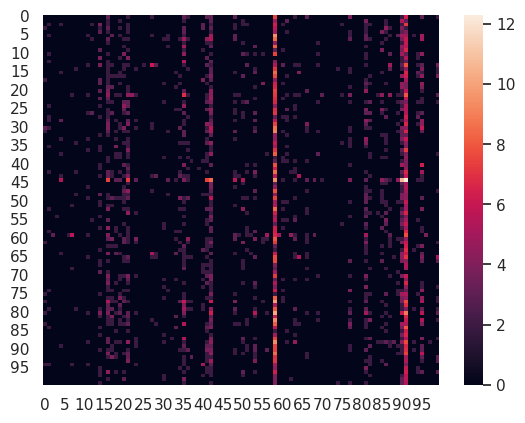

In [11]:
# visual check
sns.heatmap(mdata["rna"].X[:100, :100])

For this analysis we extract the prior information from well established databases of gene set collections such as the [MSigDB](http://www.gsea-msigdb.org/gsea/msigdb) and [Reactome](https://reactome.org/). We keep only those gene set annotations with at least 15 genes, and where at least 10% of the genes are available in the set of genes from RNA.

In [12]:
from muvi.tools import feature_sets

In [13]:
def to_upper(feature_set_collection):
    return feature_sets.FeatureSets(
        [
            feature_sets.FeatureSet([f.upper() for f in fs], fs.name)
            for fs in feature_set_collection
        ],
        name=feature_set_collection.name,
    )

In [14]:
hallmark_collection = feature_sets.from_gmt(
    "../../muvi-framework/msigdb/mh.all.v2023.2.Mm.symbols.gmt", name="hallmark"
)
reactome_collection = feature_sets.from_gmt(
    "../../muvi-framework/msigdb/m2.cp.reactome.v2023.2.Mm.symbols.gmt", name="reactome"
)

# celltype_collection = feature_sets.from_gmt(
#     "../msigdb/m8.all.v2023.2.Mm.symbols.gmt", name="celltype"
# )

celltype_collection = feature_sets.from_gmt(
    "../../muvi-framework/raw_signatures/mmc5_gene.gmt", name="celltype"
)

# merge both collections
gene_set_collection = hallmark_collection | celltype_collection
gene_set_collection = to_upper(gene_set_collection)

In [15]:
# sorted([fs.name for fs in gene_set_collection if "HAN" in fs.name])

We keep only those gene set annotations with at least 15 genes, and where at least 10% of the genes are available in the set of genes from RNA.

In [16]:
gene_set_collection = gene_set_collection.filter(
    mdata["rna"].var_names, min_fraction=0.1, min_count=15, max_count=300
)
# sorted([fs.name for fs in gene_set_collection])
gene_set_collection

<FeatureSets 'hallmark|celltype' with 56 feature sets>

In [17]:
gene_set_collection.median

69

In [18]:
mdata["rna"].varm["gene_set_mask"] = gene_set_collection.to_mask(
    mdata["rna"].var_names.tolist()
).T

In [19]:
mdata["prot"].varm["gene_set_mask"] = pd.DataFrame(False, index=mdata["prot"].var_names, columns=mdata["rna"].varm["gene_set_mask"].columns)

In [20]:
device = "cpu"
try:
    device = f"cuda:{muvi.get_free_gpu_idx()}"
except Exception as e:
    print(e)
device

'cuda:3'

In [21]:
mdata

MuData object with n_obs × n_vars = 14870 × 4112
  obs:	'cell types (high)'
  2 modalities
    rna:	14870 x 4000
      obs:	'n_proteins', 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'source'
      var:	'gene_ids', 'feature_types', 'highly_variable', 'encode', 'hvg_encode'
      uns:	'protein_names', 'version'
      obsm:	'isotypes_htos', 'protein_expression'
      varm:	'gene_set_mask'
    prot:	14870 x 112
      varm:	'gene_set_mask'

In [22]:
model = muvi.tl.from_mdata(mdata, prior_mask_key="gene_set_mask", n_factors=3, prior_confidence=0.99, nmf=True, device=device)
model

2024-12-01 11:38:57,014 - muvi.core.models - WARNING - No view names provided!
2024-12-01 11:38:57,016 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2024-12-01 11:38:57,306 - muvi.core.models - INFO - pd.DataFrame detected.
2024-12-01 11:38:57,307 - muvi.core.models - INFO - Storing the index of the view `prot` as sample names.
2024-12-01 11:38:57,309 - muvi.core.models - INFO - pd.DataFrame detected.
2024-12-01 11:38:57,312 - muvi.core.models - INFO - pd.DataFrame detected.
2024-12-01 11:38:57,313 - muvi.core.models - INFO - pd.DataFrame detected.
2024-12-01 11:38:57,319 - muvi.core.models - INFO - pd.DataFrame detected.
2024-12-01 11:38:57,320 - muvi.core.models - INFO - Storing the index of the mask `prot` as factor names.
2024-12-01 11:38:57,321 - muvi.core.models - INFO - pd.DataFrame detected.
DENSE:  1.0
2024-12-01 11:38:57,330 - muvi.core.models - INFO - Likelihoods set to `{'prot': 'normal', 'rna': 'normal'}`.
2024-12-

|==============================================|
|              MuVI version 0.1.5              |
|==============================================|
| Parameter        | Value                     |
|------------------|---------------------------|
| n_views          | 2                         |
| n_samples        | 14870                     |
| n_features       | prot: 112, rna: 4000      |
| n_factors        | 59                        |
| prior_confidence | 0.99                      |
| n_covariates     | 0                         |
| likelihoods      | prot: normal, rna: normal |
| nmf              | prot: True, rna: True     |
| reg_hs           | True                      |
| pos_transform    | relu                      |
| device           | cuda:3                    |
|==============================================|

In [23]:
model.fit(learning_rate=0.005, min_epochs=2000)

2024-12-01 11:38:57,865 - muvi.core.models - INFO - Preparing model and guide...
2024-12-01 11:38:57,976 - muvi.core.models - INFO - Preparing optimizer...
2024-12-01 11:38:57,977 - muvi.core.models - INFO - Decaying learning rate over 10000 iterations.
2024-12-01 11:38:57,979 - muvi.core.models - INFO - Preparing SVI...
2024-12-01 11:38:57,980 - muvi.core.models - INFO - Preparing training data...
2024-12-01 11:38:58,060 - muvi.core.models - INFO - Using complete dataset.
2024-12-01 11:38:58,134 - muvi.core.models - INFO - Setting training seed to `2412011138`.
2024-12-01 11:38:58,141 - muvi.core.models - INFO - Cleaning parameter store.
2024-12-01 11:38:58,143 - muvi.core.models - INFO - Starting training...


  0%|                                                 | 0/10000 [00:00<?, ?it/s]

2024-12-01 11:39:00,122 - root - INFO - Guessed max_plate_nesting = 2


 22%|██████                      | 2161/10000 [03:38<13:14,  9.87it/s, ELBO=233]

Relative improvement of -0.0001294 < 1e-05 for 10 step(s) in a row, stopping early.
2024-12-01 11:42:37,107 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


In [24]:
model._post_fit()

2024-12-01 11:42:37,878 - muvi.tools.utils - INFO - Estimating `r2` with a random sample of 1000 samples.
2024-12-01 11:42:37,949 - muvi.tools.utils - WARNING - Cache has not yet been setup, initialising model cache.


/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


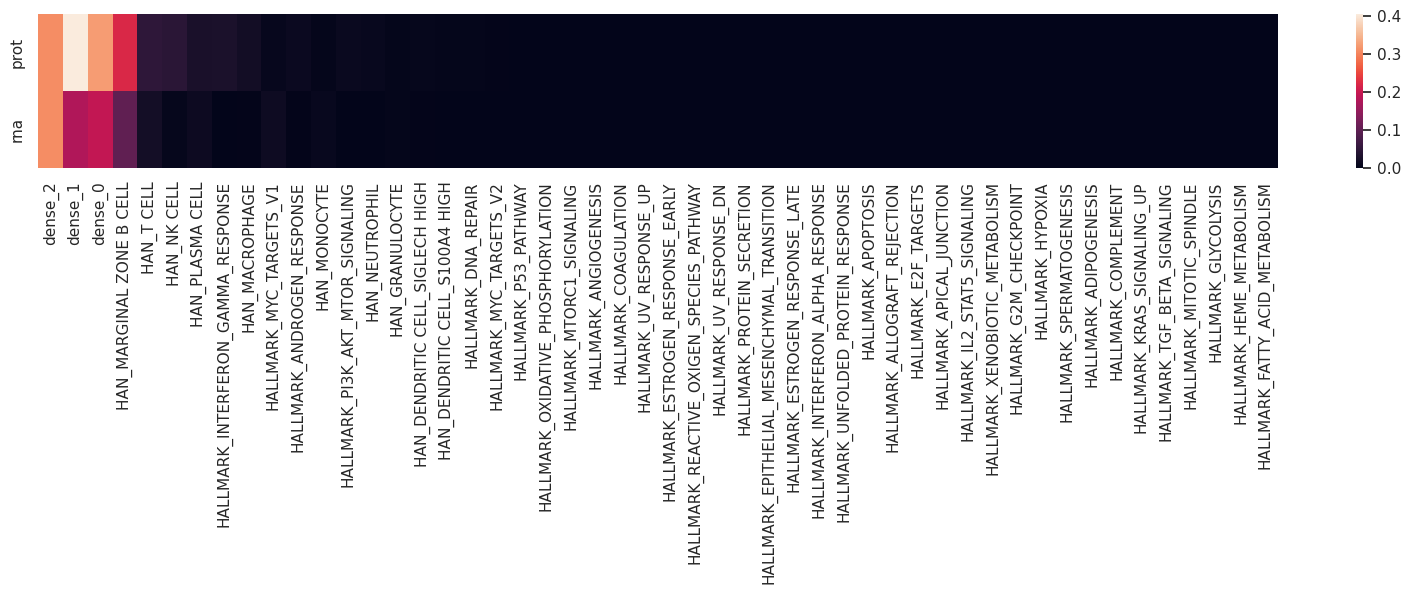

<Axes: >

In [25]:
_ = muvi.tl.variance_explained(model, subsample=1000)
muvi.pl.variance_explained(model)

In [26]:
_ = muvi.tl.test(model)

2024-12-01 11:42:41,598 - muvi.tools.utils - WARNING - No feature sets provided for `rna`, extracting feature sets from the prior mask.


100%|███████████████████████████████████████████| 56/56 [00:16<00:00,  3.47it/s]

2024-12-01 11:42:58,219 - muvi.tools.utils - WARNING - No feature sets provided for `rna`, extracting feature sets from the prior mask.



100%|███████████████████████████████████████████| 56/56 [00:16<00:00,  3.46it/s]


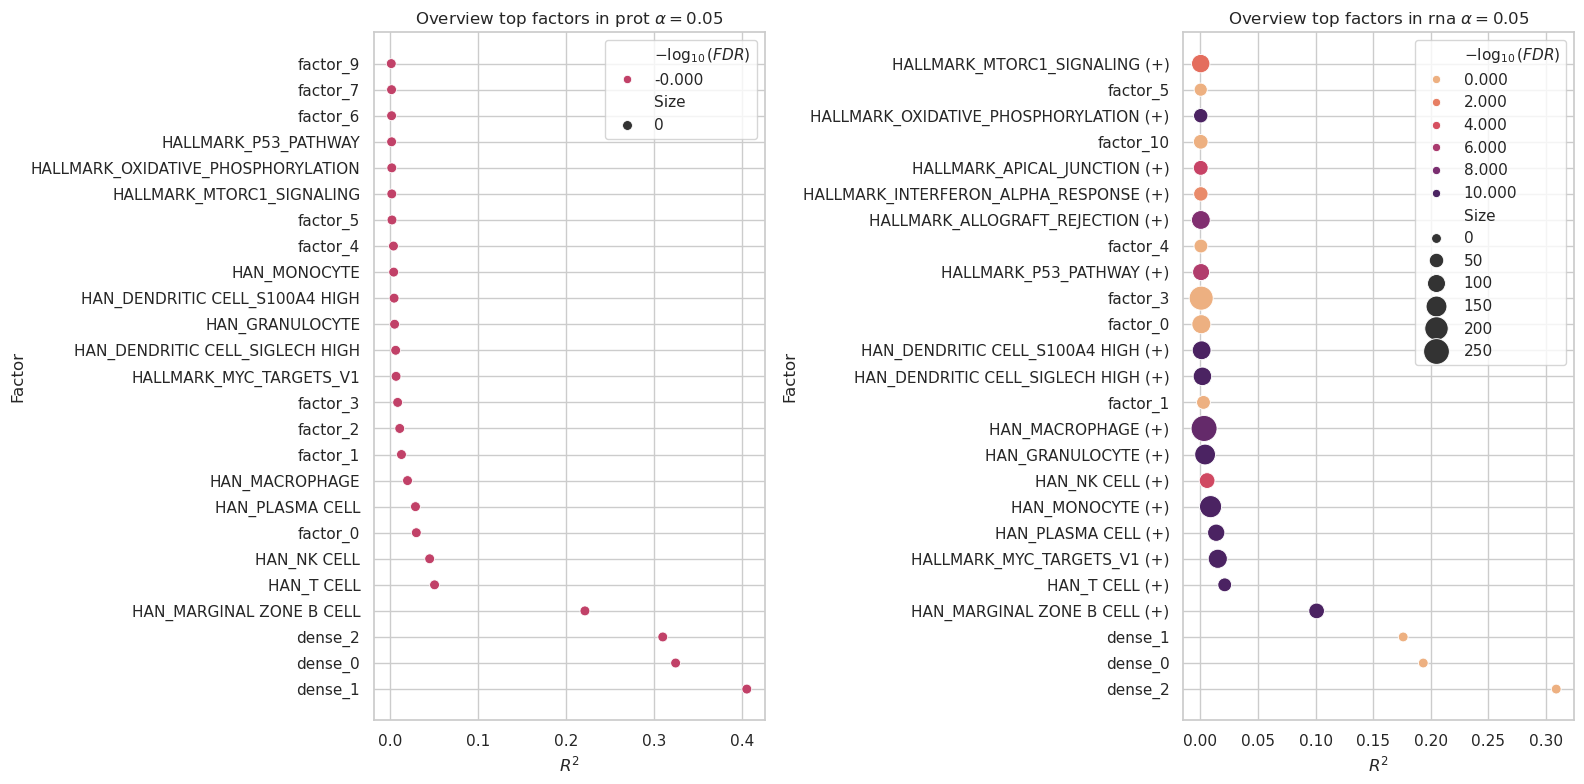

(<Figure size 1600x800 with 2 Axes>,
 array([[<Axes: title={'center': 'Overview top factors in prot $\\alpha = 0.05$'}, xlabel='$R^2$', ylabel='Factor'>,
         <Axes: title={'center': 'Overview top factors in rna $\\alpha = 0.05$'}, xlabel='$R^2$', ylabel='Factor'>]],
       dtype=object))

In [27]:
muvi.pl.factors_overview(model)

In [28]:
# add obs metadata
model._cache.factor_adata.obs = mdata.obs.copy()

In [29]:
# muvi.tl.filter_factors(model, r2_thresh=0.99)
model._cache.factor_adata

AnnData object with n_obs × n_vars = 14870 × 59
    obs: 'rna:n_proteins', 'rna:batch_indices', 'rna:n_genes', 'rna:percent_mito', 'rna:leiden_subclusters', 'rna:cell_types', 'rna:tissue', 'rna:batch', 'rna:source', 'cell types (high)'
    varm: 'metadata'

In [30]:
muvi.tl.neighbors(model)
muvi.tl.leiden(model)
muvi.tl.umap(model)

/home/aqoku/projects/code/MuVI/muvi/tools/utils.py:770: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  return cluster_fn(setup_cache(model).factor_adata, **kwargs)


... storing 'rna:source' as categorical


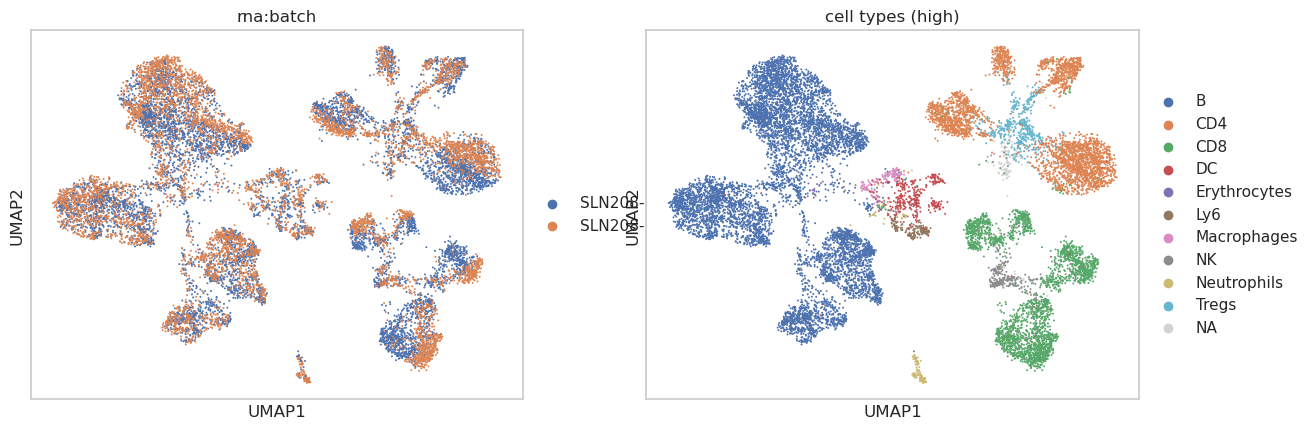

In [31]:
muvi.pl.umap(model, ["rna:batch", "cell types (high)"])

In [32]:
muvi.tl.rank(model, "rna:batch", method="wilcoxon")

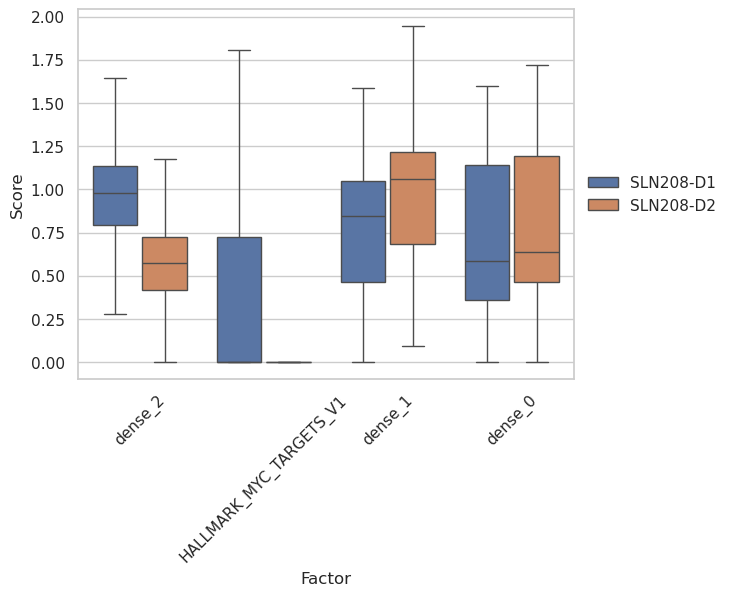

In [33]:
batch_factors, _ = muvi.pl.groupplot_rank(model, pl_type="boxplot", top=2, gap=0.1, showfliers=False)

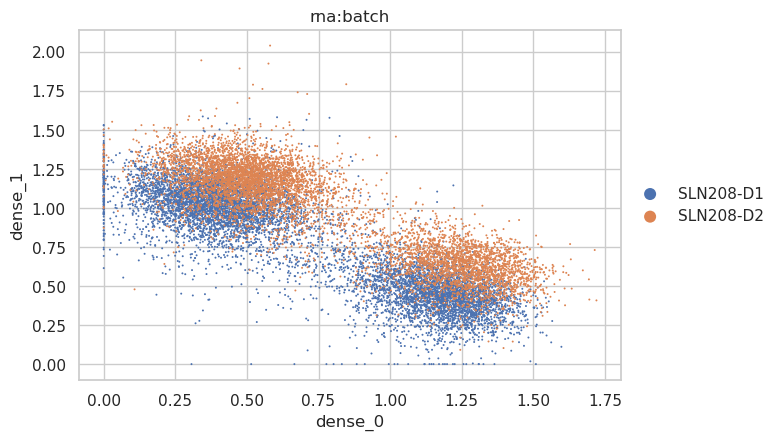

In [34]:
muvi.pl.scatter(model, "dense_0", "dense_1", groupby="rna:batch")

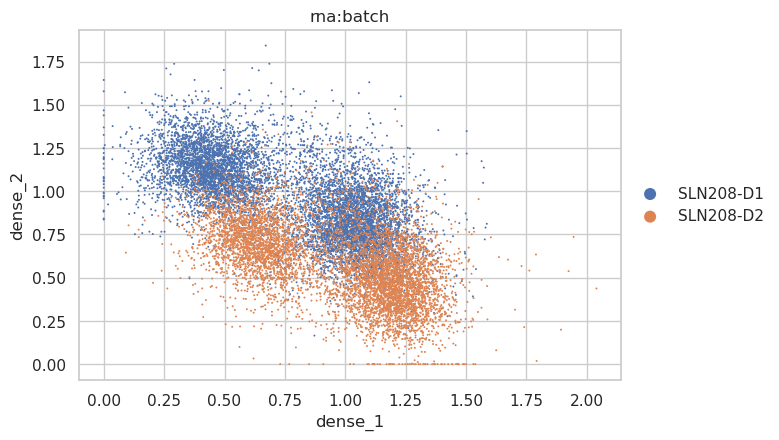

In [35]:
muvi.pl.scatter(model, "dense_1", "dense_2", groupby="rna:batch")

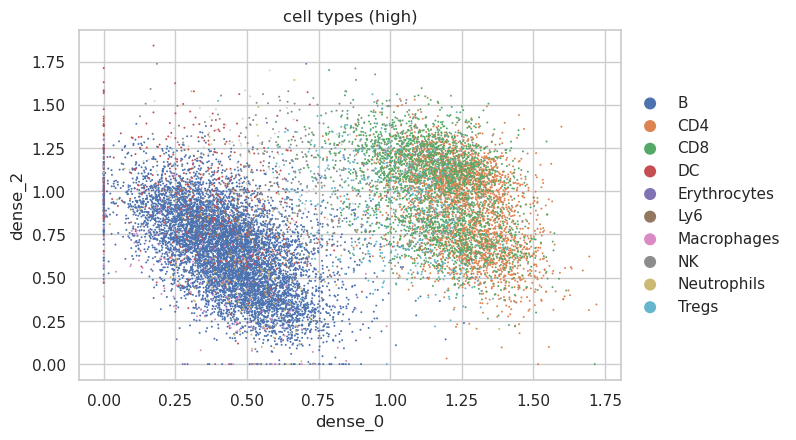

In [36]:
muvi.pl.scatter(model, "dense_0", "dense_2", groupby="cell types (high)")

In [37]:
# model._cache.factor_adata = model._cache.factor_adata[:, [fn for fn in model.factor_names if "dense" not in fn]].copy()
model._cache.factor_adata = model._cache.factor_adata[:, [fn for fn in model.factor_names if fn not in batch_factors]].copy()
model._cache.factor_adata

AnnData object with n_obs × n_vars = 14870 × 55
    obs: 'rna:n_proteins', 'rna:batch_indices', 'rna:n_genes', 'rna:percent_mito', 'rna:leiden_subclusters', 'rna:cell_types', 'rna:tissue', 'rna:batch', 'rna:source', 'cell types (high)', 'leiden'
    uns: 'neighbors', 'leiden', 'umap', 'rna:batch_colors', 'cell types (high)_colors', 'rank_genes_groups'
    obsm: 'X_umap'
    varm: 'metadata'
    obsp: 'distances', 'connectivities'

In [38]:
muvi.tl.neighbors(model)
muvi.tl.leiden(model)
muvi.tl.umap(model)

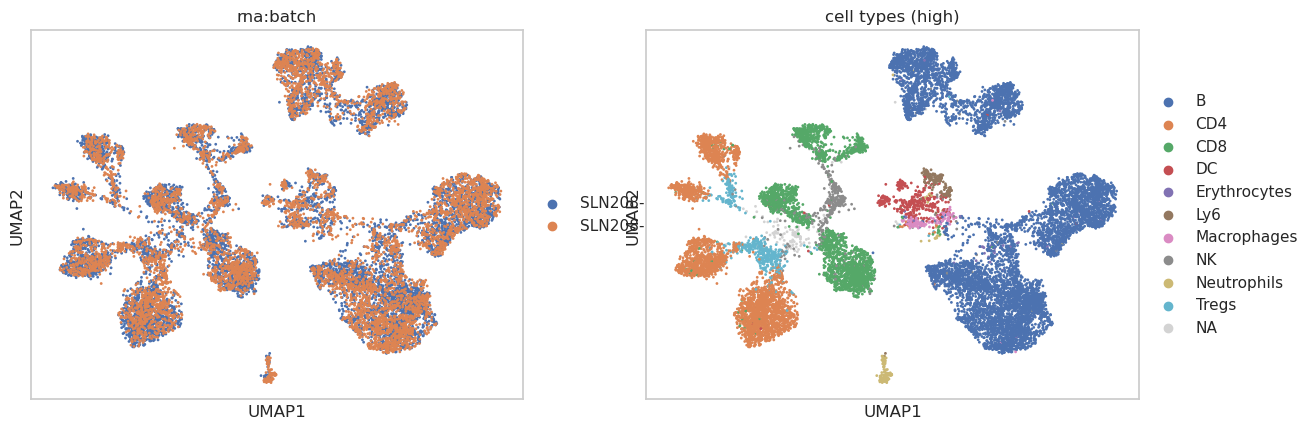

In [39]:
muvi.pl.umap(model, ["rna:batch", "cell types (high)"], size=16)

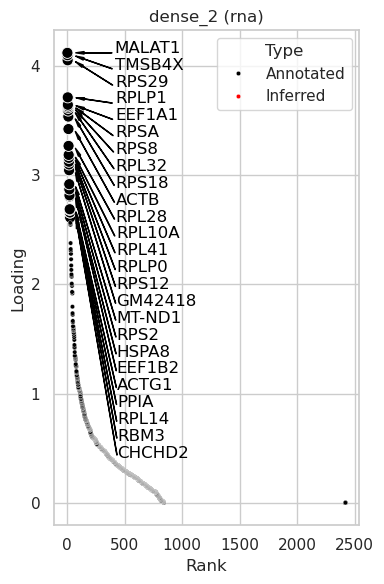

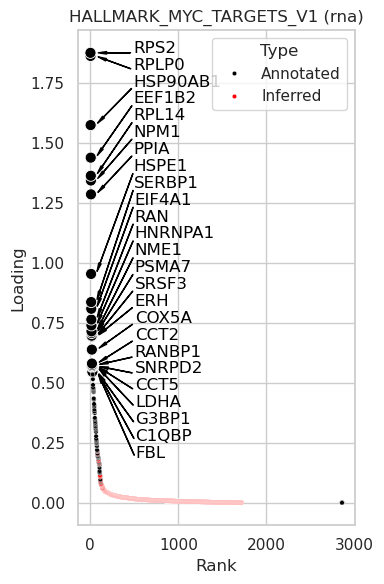

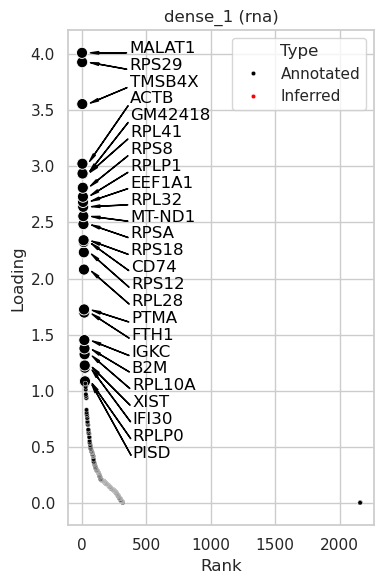

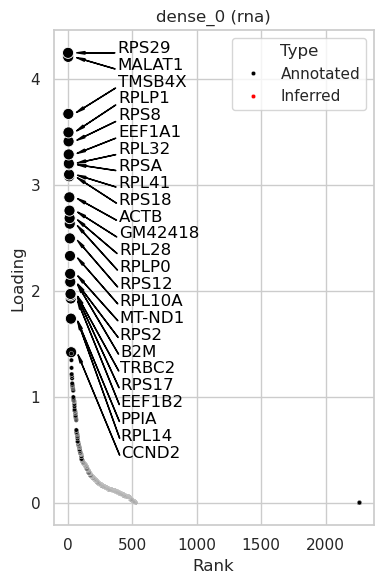

In [40]:
for rf in batch_factors:
    muvi.pl.inspect_factor(model, rf, view_idx="rna", top=25, ranked=True, figsize=(4,6))
    plt.show()

In [41]:
muvi.tl.rank(model, "cell types (high)", method="wilcoxon")

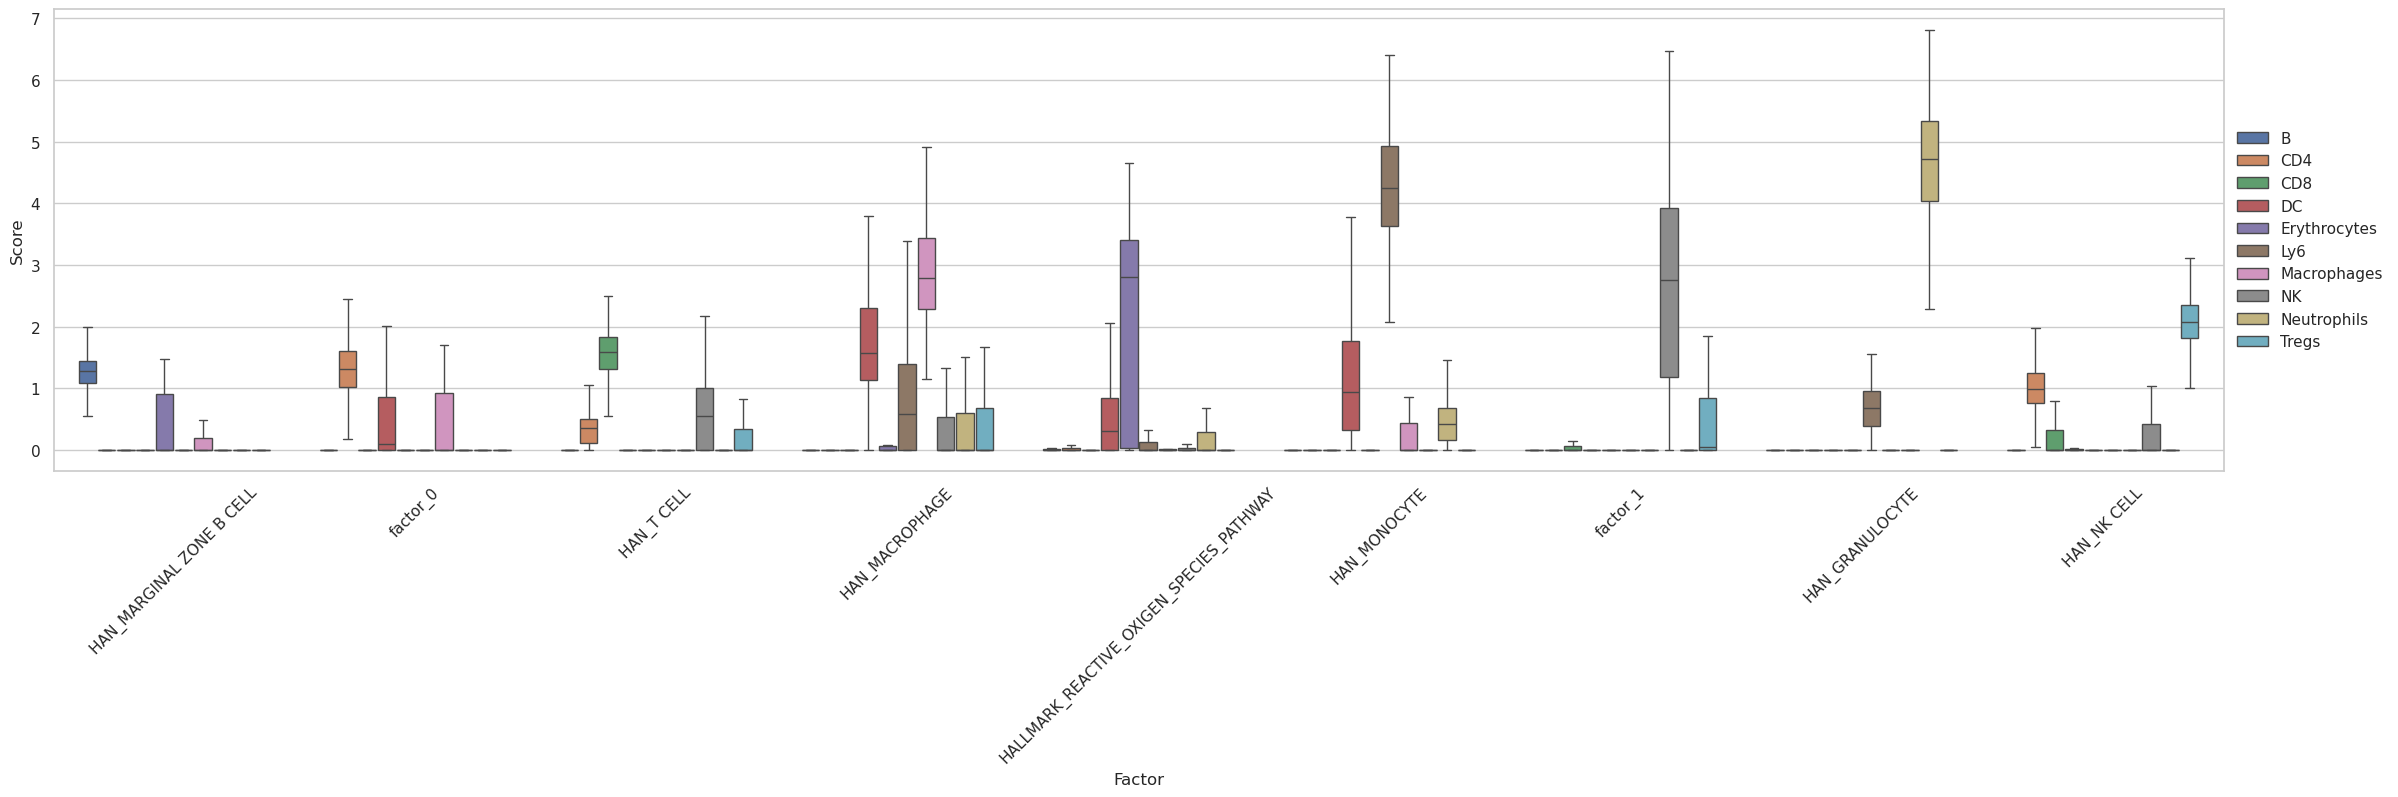

In [42]:
plt.figure(figsize=(28, 6))
celltype_factors, _ = muvi.pl.groupplot_rank(model, pl_type="boxplot", top=1, gap=0.1, showfliers=False, rot=45)

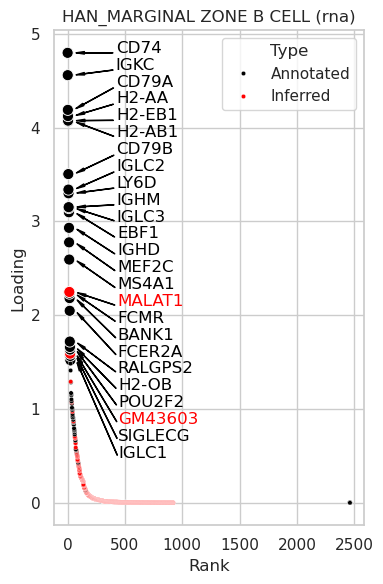

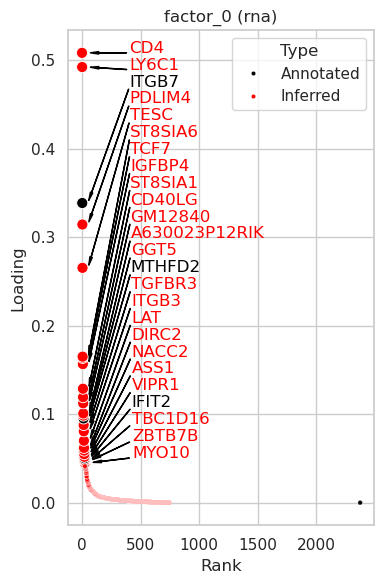

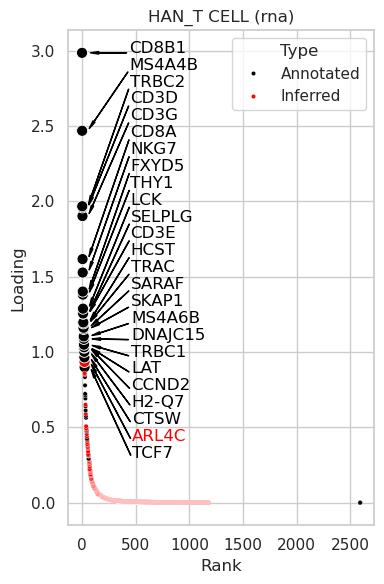

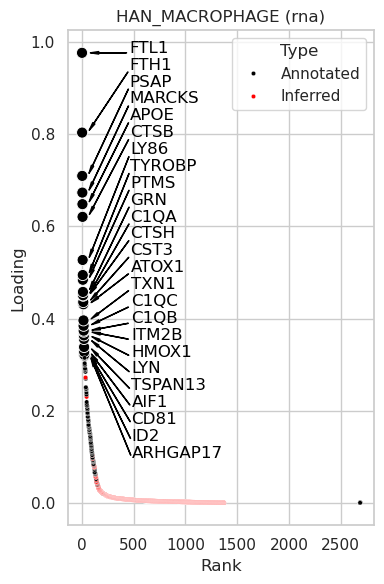

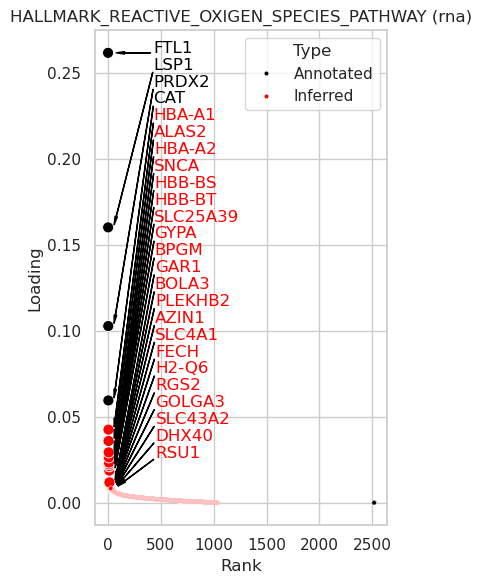

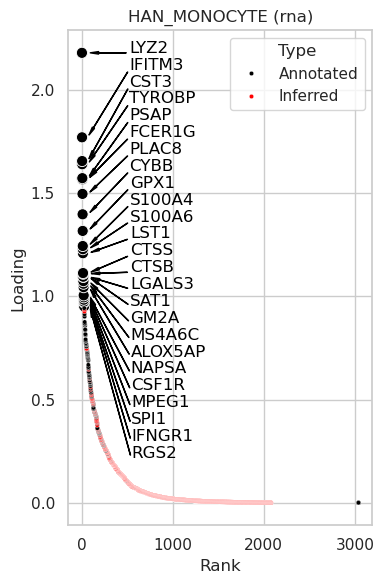

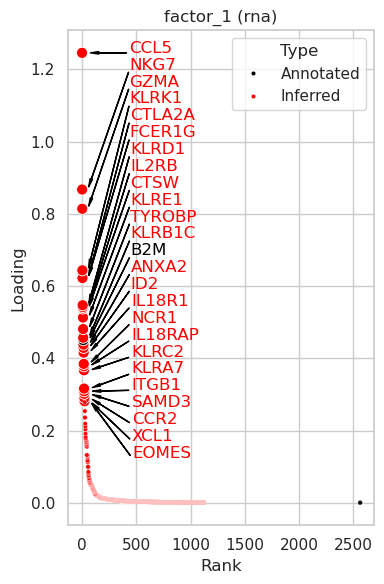

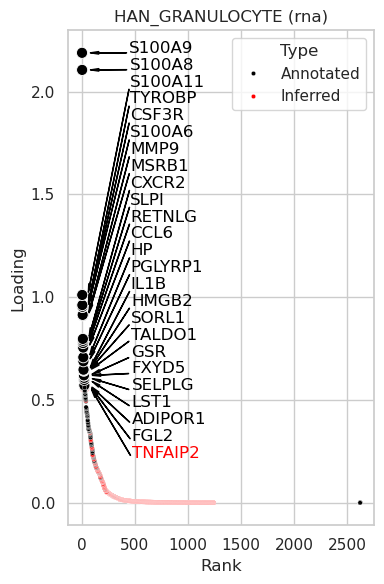

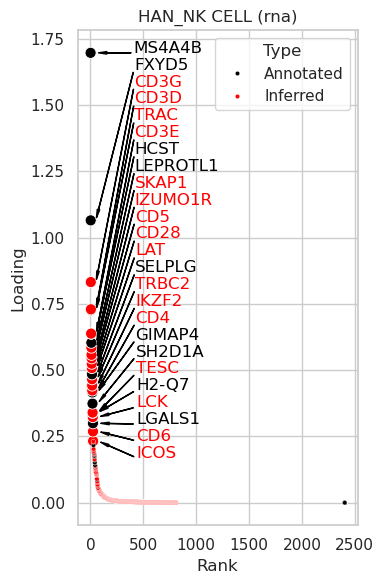

In [44]:
for rf in celltype_factors:
    muvi.pl.inspect_factor(model, rf, view_idx="rna", top=25, ranked=True, figsize=(4,6))
    plt.show()

In [45]:
from sklearn.metrics import roc_auc_score

In [46]:
celltype_factors

['HAN_MARGINAL ZONE B CELL',
 'factor_0',
 'HAN_T CELL',
 'HAN_MACROPHAGE',
 'HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY',
 'HAN_MONOCYTE',
 'factor_1',
 'HAN_GRANULOCYTE',
 'HAN_NK CELL']

In [49]:
roc_auc_score(model._cache.factor_adata.obs["cell types (high)"] == "B", model._cache.factor_adata.to_df().loc[:, "HAN_MARGINAL ZONE B CELL"])

0.9957417240861762

In [50]:
roc_auc_score(model._cache.factor_adata.obs["cell types (high)"] == "CD4", model._cache.factor_adata.to_df().loc[:, "factor_0"])

0.9727999476369042

In [ ]:
roc_auc_score(model._cache.factor_adata.obs["cell types (high)"] == "CD8", model._cache.factor_adata.to_df().loc[:, "HAN_T CELL"])

In [54]:
roc_auc_score(model._cache.factor_adata.obs["cell types (high)"] == "DC", model._cache.factor_adata.to_df().loc[:, "HAN_DENDRITIC CELL_S100A4 HIGH"])

0.7624232782826352

In [55]:
roc_auc_score(model._cache.factor_adata.obs["cell types (high)"] == "NK", model._cache.factor_adata.to_df().loc[:, "HAN_NK CELL"])

0.5262291342924035